# Functional Data Analysis with Monovariate Prediction
This notebook demonstrates the process of conducting a functional data analysis with a focus on monovariate prediction. It outlines the goal of the notebook, the dataset being used, and the main steps that will be taken.

## Setting Up the Environment
The following cells set up the environment by loading necessary libraries and defining the path to the simulation file.

In [174]:
# @__DIR__ is the directory of the current file
# We need to go up to the parent directory to find the project root
project_root = dirname(dirname(@__DIR__))


include(joinpath(project_root, "setup", "init_env.jl"))
set_R_lib_path(project_root)
using Plots


  Activating project at `c:\Users\User\Documents\repos\TESI\tesi_data\progetto_s_on_f.md\b_spline\functional-data-regression-mip`


## Load Data and Run R Simulation
Here we load the data required for the simulation and run the R simulation script to prepare the data for analysis.

**NOTICE** -> The seed should be the same for both the training and the test datasets, otherwise the data distribution will be different. 
This is very important specifically in the "Paper simulation" where the predictors shape depends on the coefficients a1,...f3 extracted from Uniform and Normal distributions.  

In [175]:
include(joinpath(project_root, "src", "Julia", "utils", "simulation.jl"))


simulation_name = "paper"
simulation_settings_file = "default"

measurements = 300
basis_functions = 45
params_train = (
    observations = 500,
    measurements = measurements,
    basis_functions = basis_functions,
    noise_snr = [100,100],
    seed = 1
)

params_test = (
    observations = 300,
    measurements = measurements,
    basis_functions = basis_functions,
    noise_snr = [10,10],
    seed = 300
)

# Note: Use ... to unpack NamedTuple into keyword arguments
output = load_simulation_data(simulation_name, simulation_settings_file, project_root; params_train...)

output_test = load_simulation_data(simulation_name, simulation_settings_file, project_root; params_test...)


# Grab the outputs from the R script

predictors = Int(output[:predictors])
true_predictors = output[:true_predictors]
intercept = output[:intercept]
observations = Int(output[:observations])

# betas and basis
beta_matrix  = output[:B]
basis_objs   = output[:basis_objs]
basis_values = output[:basis_values]
time_domains = output[:time_domains]

# matrixes 
U = output[:U]
X = output[:X]
Y = output[:Y]
Z = output[:Z]
J = output[:J]
W = output[:W]


X_test = output_test[:X]
Y_test = output_test[:Y]
Z_test = output_test[:Z]
J_test = output_test[:J]
W_test = output_test[:W]



[1] "predictors: 6"
[1] "observations: 500"
[1] "measurements: 300"
[1] "basis_functions: 45"
[1] "intercept: 0"
[1] "predictors: 6"
[1] "observations: 300"
[1] "measurements: 300"
[1] "basis_functions: 45"
[1] "intercept: 0"


300×6×45 Array{Float64, 3}:
[:, :, 1] =
 11.4696    1.25955     7.05361  -0.885247  -6.44262   8.29239
  7.32672   1.37725     6.387     0.995323  -6.86241   4.47442
  4.09228   0.897442    3.1165    0.275076  -6.3503   14.6388
  7.49149   1.67533     6.73084  -0.889802  -7.16465  11.9389
  5.49919   0.56607     8.06827  -0.668567  -8.21219   8.08056
  5.09059  -1.78827     6.41655  -0.778312  -7.70467  10.2755
  4.85203  -0.669218    9.63973   0.913667  -8.22687   8.56125
  7.68559  -0.269355   10.2721    0.42846   -9.37776   8.42129
  5.85746  -1.50891     5.99366   0.436093  -8.05967  -0.115661
  6.19147   1.87391     7.58923  -0.376264  -6.98568   8.34663
  7.30349   1.7841      5.78377   0.381073  -6.88684  10.51
 10.3589    2.40181     4.87815  -0.885211  -6.45259  12.4757
  6.56094   1.35531     5.65839  -0.63411   -8.91918   6.22858
  ⋮                                                    ⋮
  8.41671   0.880472    7.60909   0.879691  -8.61781  13.0089
  4.67836   0.0113964   5.48

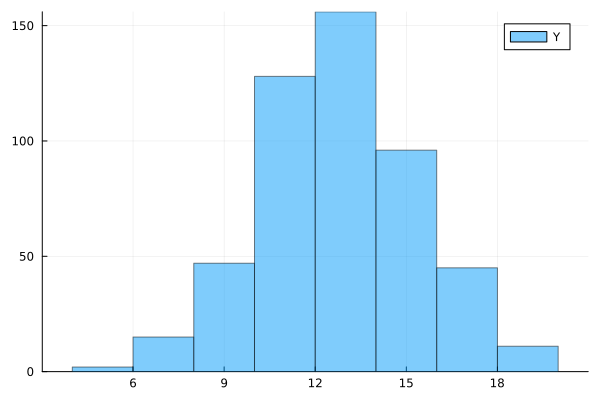

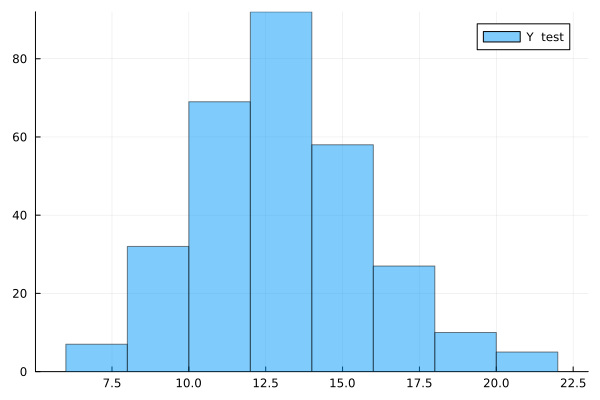

In [176]:
using Plots
h1= histogram(Y, bins=10, alpha=0.5, label="Y ")
display(h1)
h2= histogram(Y_test, bins=10, alpha=0.5, label="Y  test")
display(h2)

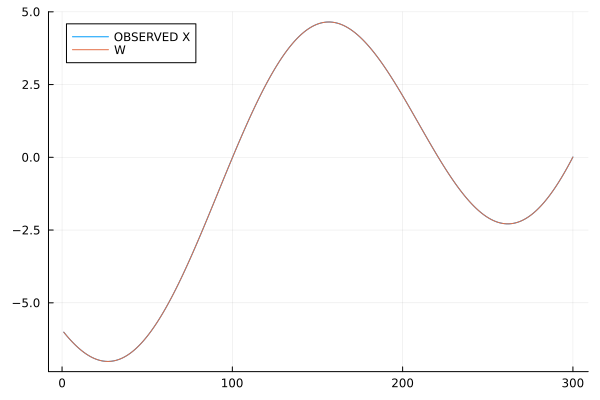

In [177]:
#  plot(U[1,1,:], label="TRUE U", legend=:topleft)
i = 6
p = 5
plot(X[i,p,:], label="OBSERVED X", legend=:topleft)
plot!(basis_values[p,:,:] * W[i, p, :], label="W", legend=:topleft)


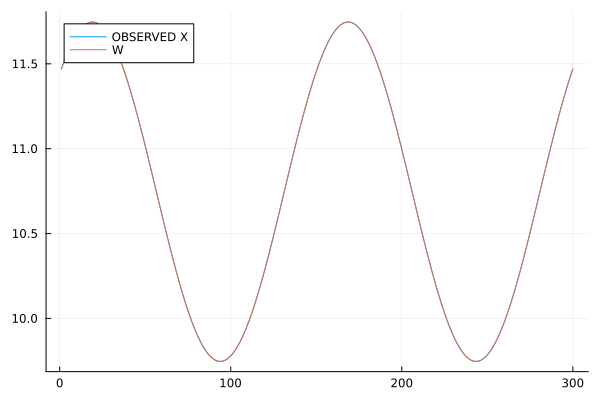

In [178]:
#  plot(U[1,1,:], label="TRUE U", legend=:topleft)
plot(X_test[1,1,:], label="OBSERVED X", legend=:topleft)
plot!(basis_values[1,:,:] * W_test[1, 1, :], label="W", legend=:topleft)


### Training Data Statistics

In [179]:
println("Real \t",Y[i])
# Get the number of predictors
num_predictors = size(W, 2)

# Initialize an empty array to store the results
results = []
i = 12
# Loop over each predictor
for j in 1:num_predictors
  # Perform the operation and store the result
  result = transpose(W[i,j,:]) * J[j,:,:] * beta_matrix[j,:] #Z[i, j, :]' * beta_matrix[j,:]
  push!(results, result)
end

# Print the results
println("Approximated \t",sum(results))

Real 	15.069352793914783
Approximated 	7.985848007938042


In [180]:
EER = sum(Y[i]-sum(Z[i, j, :]' * beta_matrix[j,:] for j in 1:num_predictors) for i in 1:observations)
# NOW COMPUTE rmse_predictions
rmse = sqrt(sum((Y[i]-sum(Z[i, j, :]' * beta_matrix[j,:] for j in 1:num_predictors))^2 for i in 1:observations)/observations)
EER, rmse 
#  (-2.3588186494659005, 0.045628452180059516)
#   -2.6107235285160333, 0.04561947150934014

# (8.380748239267355, 0.00041903790906202366)

(-0.9442816949722701, 0.2512373982472394)

In [181]:
# EER = sum(Y[i]-sum(Z[i, j, :]' * beta_matrix[j,:] for j in 1:num_predictors) for i in 1:observations)
# # NOW COMPUTE rmse_predictions
# rmse = sqrt(sum((Y[i]-sum(Z[i, j, :]' * beta_star[j,:] for j in 1:num_predictors))^2 for i in 1:observations)/observations)
# EER, rmse 
# #  (-2.3588186494659005, 0.045628452180059516)
# #   -2.6107235285160333, 0.04561947150934014

# # (8.380748239267355, 0.00041903790906202366)

### Let's plot the data

The `plot_predictor_observations` function is used to plot the functional data for a specified predictor across multiple observations. It starts by plotting the first observation and then iteratively adds the remaining observations to the same plot. This function is useful for visualizing how a predictor behaves across different samples.
The `plot_transformed_W` function plots the matrix `W` after transforming it with the corresponding basis values. This is done for a specific predictor across multiple observations. The transformation involves a matrix multiplication of the basis values with the `W` matrix for each observation, which is then plotted. This visualization helps in understanding the effect of the basis transformation on the weights `W`.
Finally, the `plot_Z_observations` function plots the observations from the `Z` matrix for a given predictor. This is similar to the first function but applies to the `Z` matrix, which often contains the true or observed values before any transformation or modeling is applied.



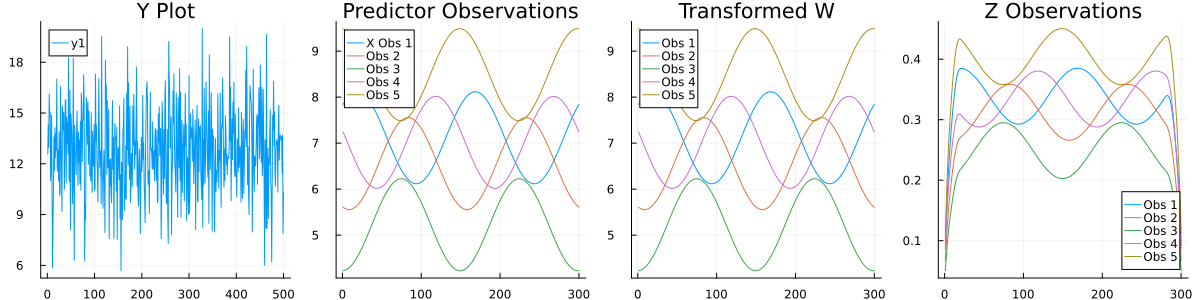

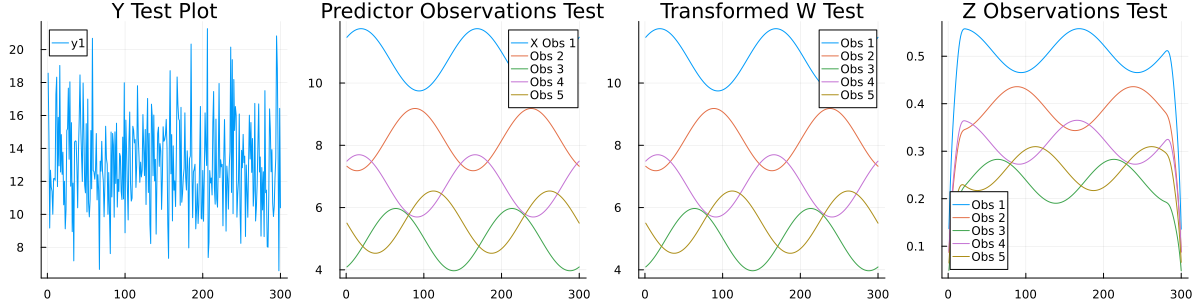

In [182]:
# Function to plot multiple observations for a single predictor
function plot_predictor_observations(X, predictor, obs, plot_title)
    p = plot(X[1, predictor, :], label = "X Obs 1", title = plot_title)  # Start with the first observation
    for i in 2:obs
        plot!(p, X[i, predictor, :], label = "Obs $i")  # Add the rest
    end
    return p
end

# Function to plot the W matrix transformed by the basis values
function plot_transformed_W(basis_values, W, predictor, obs, plot_title)
    p = plot(basis_values[predictor,:,:] * W[1, predictor, :], label = "Obs 1", title = plot_title)  # Start with the first observation
    for i in 2:obs
        plot!(p, basis_values[predictor,:,:] * W[i, predictor, :], label = "Obs $i")  # Add the rest
    end
    return p
end

# Function to plot Z for multiple observations
function plot_Z_observations(Z, predictor, obs, plot_title)
    p = plot( basis_values[predictor,:,:] * Z[1, predictor, :], label = "Obs 1", title = plot_title)  # Start with the first observation
    for i in 2:obs
        plot!(p, basis_values[predictor,:,:] * Z[i, predictor, :], label = "Obs $i")  # Add the rest
    end
    return p
end

# Initialize the plot for predictors
predictor = 1
obs = 5  # Limiting to the first 20 observations for clarity

# Plot Y and Y_test
pY = plot(Y, title = "Y Plot")
pY_test = plot(Y_test, title = "Y Test Plot")

# Plot the predictor, transformed W, and Z for both non-test and test data
p1 = plot_predictor_observations(X, predictor, obs, "Predictor Observations")
p2 = plot_transformed_W(basis_values, W, predictor, obs, "Transformed W")
p3 = plot_Z_observations(Z, predictor, obs, "Z Observations")

p11 = plot_predictor_observations(X_test, predictor, obs, "Predictor Observations Test")
p22 = plot_transformed_W(basis_values, W_test, predictor, obs, "Transformed W Test")
p33 = plot_Z_observations(Z_test, predictor, obs, "Z Observations Test")

# Combining plots side by side
p_non_test = plot(pY, p1, p2, p3, layout = (1, 4), size = (1200, 300))
p_test = plot(pY_test, p11, p22, p33, layout = (1, 4), size = (1200, 300))

# Displaying the combined plots
display(p_non_test)
display(p_test)

## Plotting the Y, Z, W, Basis
Visualize the processed input data to understand its distribution and structure before running the model.

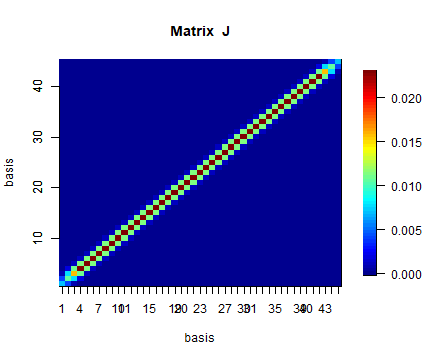

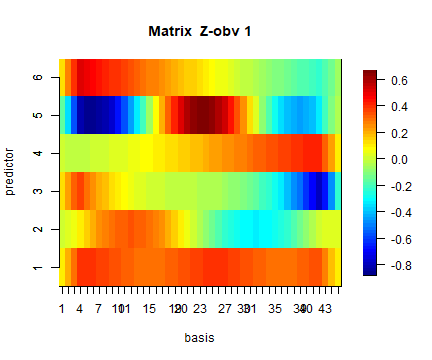

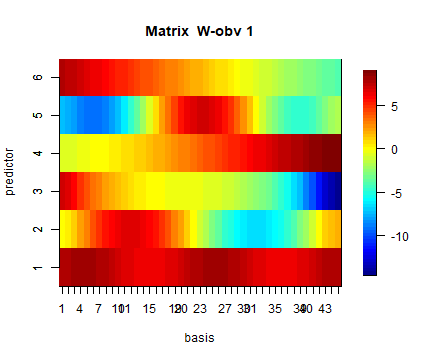

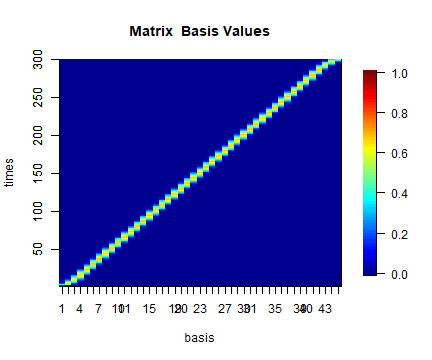

RObject{RealSxp}
 [1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45


In [183]:
using RCall

@rput J Z W basis_values
R"""
source(here("src", "R", "generic_simulator", "utils", "plot_utilities.R"))

plot_design_matrix(J[1,,], "J", "basis","basis")
#loop over the rows of Z in R code
for( i in 1:1 ) {
    plot_design_matrix(Z[i, ,], paste("Z-obv",i),"basis", "predictor")
    plot_design_matrix(W[i, ,], paste("W-obv",i),"basis", "predictor")
}
plot_design_matrix(basis_values[1,,], "Basis Values", "basis","times")

"""

## Model Execution
Run the predictive model using the prepared data.

In [211]:
model_name = "l0_limit_MU_ML" 
# model_name = "l0_limit_M"
model_file_path = joinpath(project_root, "src", "Julia","models", model_name *".jl")

include(model_file_path)

λ = 0
λ_group = 0
#M = [3,1,0,0,0,0]#
M = zeros(length(true_predictors)) .+ 5#maximum(abs.(beta_matrix))
# M = zeros(length(true_predictors)) .+ 10
# data = [
#     1.569934e-02  1.457374e-02  2.000958e-03  3.370529e-02  -5.753362e-04  3.255108e-04
#     8.264664e-06  1.090621e-05  7.130755e-07  1.871545e-05  1.670581e-07  6.620571e-08
#     4.690114e-01  8.109023e-01  9.571828e-03  1.037594e+00  2.874453e-02  -5.704280e-04
#     4.737688e-01  8.700572e-01  2.536293e-01  7.832537e-01  -3.827963e-02  4.026181e-03
#     9.895640e-01  1.419081e+00  -5.943693e-02  1.202684e+00  3.752100e-02  -6.119584e-03
#     6.710540e-01  5.403322e-01  -7.882889e-02  6.931978e-01  1.406572e-01  -1.546046e-02
# ]
data = beta_matrix
scaling = 15.01
UB_M = data .+ abs.(data) * scaling
LB_M = data .- abs.(data) * scaling

# maxes = maximum((data), dims=2)
# mins = minimum((data), dims=2)

 

# UB_M = repeat(maxes, 1, size(data, 2))  #max.(LB_M, -maxes)
# LB_M = repeat(mins  , 1, size(data, 2)) #max.(LB_M, -maxes)
# where UB_M AND LB_M ARE zero, SUBSTITUE WITH 1
# UB_M[UB_M .== 0] .= 2
# LB_M[LB_M .== 0] .= -2

to_predict = sum(true_predictors)
# beta_star, alpha_star, groups = mip_functional_regression(Y, Z, λ, λ_group, M; intercept = output[:intercept] != 0, group_limit= to_predict)
beta_star, alpha_star, groups = mip_functional_regression(Y, Z, λ, λ_group, UB_M, LB_M; intercept = output[:intercept] != 0, group_limit= to_predict) #initial_beta=beta_matrix, initial_group = Int.(true_predictors), initial_alpha = intercept)



Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Set parameter TimeLimit to value 1800
Set parameter Presolve to value 2
Set parameter Heuristics to value 1
Set parameter MIPGap to value 0.01
Set parameter MIPFocus to value 1
Set parameter NumericFocus to value 3
Set parameter NonConvex to value 2
Set parameter OptimalityTol to value 1e-05
Set parameter IntFeasTol to value 1e-06
Set parameter TimeLimit to value 1800
Set parameter NumericFocus to value 3
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 1
Set parameter MIPGap to value 0.01
Set parameter OptimalityTol to value 1e-05
Set parameter IntFeasTol to value 1e-06
Set parameter NonConvex to value 2
Set parameter Presolve to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 5

([0.0 0.013055916303164494 … 1.8288125124933625 1.366683667332543; 4.240069436890279e-9 0.0312516274912073 … -0.9404524276896762 -1.0884726531376785; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 0, [1, 1, 0, 1, 0, 0])

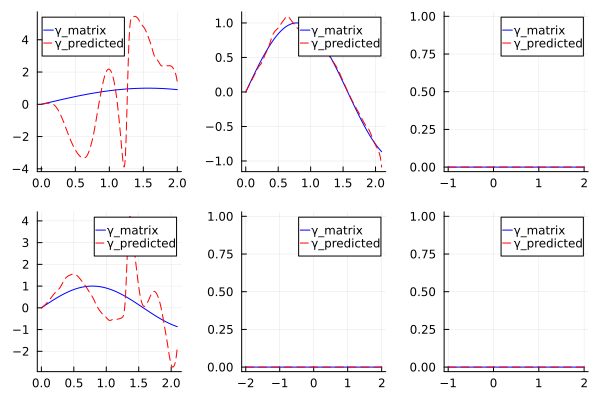

"c:\\Users\\User\\Documents\\repos\\TESI\\tesi_data\\progetto_s_on_f.md\\b_spline\\functional-data-regression-mip\\outputs\\plots\\paper\\combined.png"

In [224]:
project_root = dirname( dirname(@__DIR__))
plot_file_path = joinpath(project_root, "src", "Julia","utils", "plot.jl")

include(plot_file_path)

output_folder= joinpath(project_root, "outputs", "plots", simulation_name)

beta_point_values = output[:beta_point_values]
# plot_combined_predicted_curve(beta_point_values, beta_star,basis_values, time_domains,output_folder, true; upper_bound = UB_M, lower_bound = LB_M)
  plot_combined_predicted_curve(beta_point_values, beta_star,basis_values, time_domains,output_folder, true)



## Model Results
Display the results of the model, including the estimated beta coefficients.

In [213]:
UB_M

6×45 Matrix{Float64}:
 1.7091e-9  0.254127  0.762381  …  15.1312  14.8641  14.6636  14.5579
 6.8869e-8  0.532242  1.59673      10.5219  11.3941  11.9001  12.133
 0.0        0.0       0.0           0.0      0.0      0.0      0.0
 6.8869e-8  0.532242  1.59673      10.5219  11.3941  11.9001  12.133
 0.0        0.0       0.0           0.0      0.0      0.0      0.0
 0.0        0.0       0.0       …   0.0      0.0      0.0      0.0

In [214]:
LB_M

6×45 Matrix{Float64}:
 -1.4956e-9   -0.222381  -0.667143  -1.33277  …  -13.0073  -12.8318  -12.7393
 -6.02658e-8  -0.465753  -1.39726   -2.78063     -13.0207  -13.5989  -13.8651
  0.0          0.0        0.0        0.0           0.0       0.0       0.0
 -6.02658e-8  -0.465753  -1.39726   -2.78063     -13.0207  -13.5989  -13.8651
  0.0          0.0        0.0        0.0           0.0       0.0       0.0
  0.0          0.0        0.0        0.0      …    0.0       0.0       0.0

In [215]:
beta_matrix # true beta

6×45 Matrix{Float64}:
 1.06752e-10  0.015873   0.047619   …   0.928427   0.915903   0.909297
 4.30163e-9   0.0332444  0.0997331     -0.813285  -0.849403  -0.866025
 0.0          0.0        0.0            0.0        0.0        0.0
 4.30163e-9   0.0332444  0.0997331     -0.813285  -0.849403  -0.866025
 0.0          0.0        0.0            0.0        0.0        0.0
 0.0          0.0        0.0        …   0.0        0.0        0.0

In [216]:
beta_star  # estimated beta

6×45 Matrix{Float64}:
 0.0         0.0130559  0.0419037  …   2.19375    1.82881    1.36668
 4.24007e-9  0.0312516  0.0917146     -0.838534  -0.940452  -1.08847
 0.0         0.0        0.0            0.0        0.0        0.0
 4.32642e-9  0.0344029  0.112738      -2.78808   -2.36098   -1.80569
 0.0         0.0        0.0            0.0        0.0        0.0
 0.0         0.0        0.0        …   0.0        0.0        0.0

In [217]:
groups,true_predictors

([1, 1, 0, 1, 0, 0], [1.0, 1.0, 0.0, 1.0, 0.0, 0.0])

In [218]:
alpha_star

0

## Final Output
Plot the combined predicted curve and save the output for further analysis.

## Evaluate Model Performance
Evaluate the model's performance using various metrics such as MSE, RMSE, MAE, and relative error.

In [219]:

using Statistics 
using LinearAlgebra

include(joinpath(project_root, "src", "Julia", "utils", "data_analysis.jl"))

performance_metrics = compute_metrics(Y_test, Z_test, beta_matrix, beta_matrix, alpha_star, groups, predictors)


Dict{String, Float64} with 11 entries:
  "Functional_Correlation" => 0.958802
  "CDF_Distance"           => 0.178472
  "R_squared"              => 0.918474
  "RMSE_Predictions"       => 0.787463
  "RMSE_Coefficients"      => 0.0
  "Area_Between_Curves"    => 187.026
  "ISE_Coefficients"       => 0.0
  "MSE_Predictions"        => 0.620098
  "Adjusted_R_squared"     => 0.916843
  "MSE_Coefficients"       => 0.0
  "MAE_Predictions"        => 0.62342

In [220]:

using Statistics 
using LinearAlgebra

include(joinpath(project_root, "src", "Julia", "utils", "data_analysis.jl"))

performance_metrics = compute_metrics(Y_test, Z_test, beta_matrix, beta_star, alpha_star, groups, predictors)


Dict{String, Float64} with 11 entries:
  "Functional_Correlation" => 0.958869
  "CDF_Distance"           => 0.178086
  "R_squared"              => 0.918484
  "RMSE_Predictions"       => 0.787414
  "RMSE_Coefficients"      => 1.18051
  "Area_Between_Curves"    => 187.181
  "ISE_Coefficients"       => 376.274
  "MSE_Predictions"        => 0.620021
  "Adjusted_R_squared"     => 0.916847
  "MSE_Coefficients"       => 1.39361
  "MAE_Predictions"        => 0.623937

## Residual Analysis
Analyze the residuals from the model to check for any patterns that might suggest issues with the model.

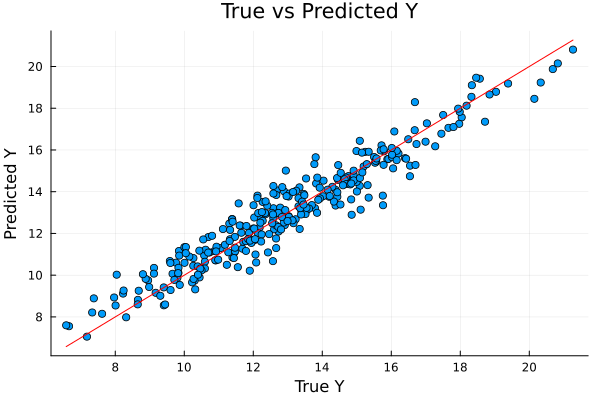

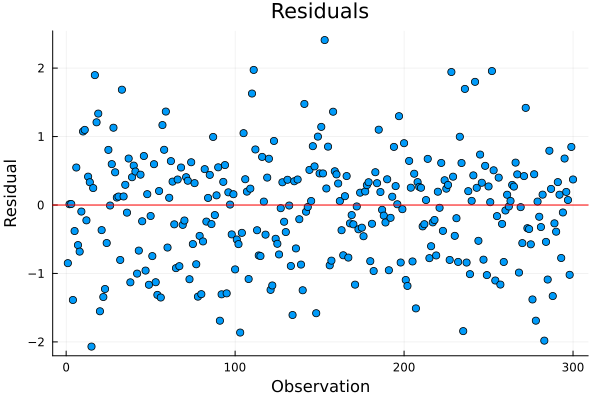

In [221]:
using Plots
include(joinpath(project_root, "src", "Julia", "utils", "data_analysis.jl"))

Y_pred = get_predictions(Z_test, beta_star, alpha_star)
# 1. Scatter plot comparing true vs predicted values
scatter(Y_test, Y_pred, xlabel="True Y", ylabel="Predicted Y", legend=false, title="True vs Predicted Y")
plot!(Y_test, Y_test, color=:red)  # A y=x line for reference
display(plot!())

# 2. Plot residuals
residuals = Y_test - Y_pred
scatter(1:length(Y_test), residuals, xlabel="Observation", ylabel="Residual", legend=false, title="Residuals")
hline!([0], color=:red, label="Zero line")
display(plot!())


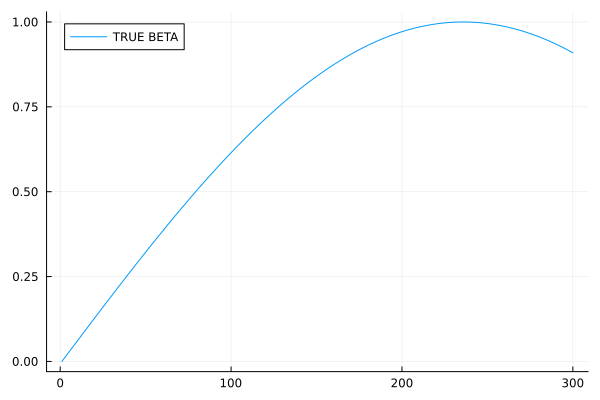

In [222]:
plot(beta_point_values[1,:], label="TRUE BETA", legend=:topleft)


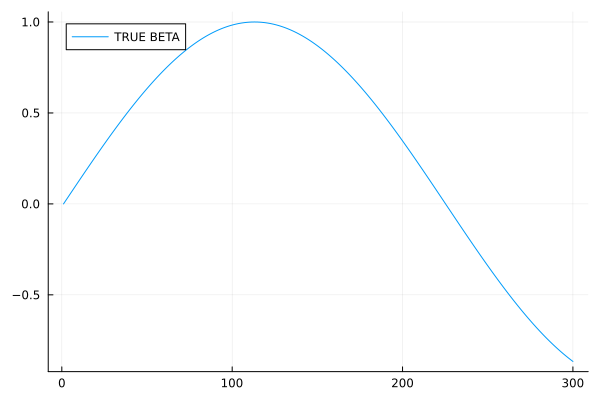

In [223]:
plot(beta_point_values[2,:], label="TRUE BETA", legend=:topleft)
